# Food app

### Consignes OpenClassRoom

Les données

Extrait de l’appel à projets :

    Le jeu de données Open Food Fact est disponible sur le site officiel. Les variables sont définies à cette adresse.

    Les champs sont séparés en quatre sections :

        Les informations générales sur la fiche du produit : nom, date de modification, etc.
        Un ensemble de tags : catégorie du produit, localisation, origine, etc.
        Les ingrédients composant les produits et leurs additifs éventuels.
        Des informations nutritionnelles : quantité en grammes d’un nutriment pour 100 grammes du produit.

Votre mission

Après avoir lu l’appel à projets, voici les différentes étapes que vous avez identifiées :

1) Traiter le jeu de données afin de repérer des variables pertinentes pour les traitements à venir. Automatiser ces traitements pour éviter de répéter ces opérations.

Le programme doit fonctionner si la base de données est légèrement modifiée (ajout d’entrées, par exemple).

2) Tout au long de l’analyse, produire des visualisations afin de mieux comprendre les données. Effectuer une analyse univariée pour chaque variable intéressante, afin de synthétiser son comportement.

L’appel à projets spécifie que l’analyse doit être simple à comprendre pour un public néophyte. Soyez donc attentif à la lisibilité : taille des textes, choix des couleurs, netteté suffisante, et variez les graphiques (boxplots, histogrammes, diagrammes circulaires, nuages de points…) pour illustrer au mieux votre propos.

3) Confirmer ou infirmer les hypothèses  à l’aide d’une analyse multivariée. Effectuer les tests statistiques appropriés pour vérifier la significativité des résultats. **QUELS RESULTATS ?? **

4) Élaborer une idée d’application. Identifier des arguments justifiant la faisabilité (ou non) de l’application à partir des données Open Food Facts.

5) Rédiger un rapport d’exploration et pitcher votre idée durant la soutenance du projet.
 Livrables attendus

    Un notebook du nettoyage des données (non cleané, pour comprendre votre démarche). 
    Un notebook d’exploration comportant une analyse univariée, multivariée, une réduction dimensionnelle, ainsi que les différentes questions de recherches associées (non cleané, pour comprendre votre démarche).
    Une présentation, à utiliser en support pour la soutenance, comprenant :
        La présentation de votre idée d’application.
        Les opérations de nettoyage effectuées.
        La description et l'analyse univariée des différentes variables importantes avec les visualisations associées.
        L’analyse multivariée et les résultats statistiques associés, en lien avec votre idée d’application.
        3 observations solidement étayées (graphes et/ou tests statistiques à l’appui au besoin) évaluant la pertinence et la faisabilité de votre application.
        La synthèse des différentes conclusions sur la faisabilité de votre projet.



## PLAN


0. Trouver idée d'application

I. CLEAN
 - 1. Comprehension variables --> Selection variables
 - 2. Inputer pour nan ?

II.ANALYSE EXPLORATOIRE
 - 1. Univarié
 - 2. Bivarié
 - 3. Multivarié : PCA +ANOVA
 
III.PRESENTATION
 - Graphique => Verif Hypothèse ou Declenchement action sur DF


In [1]:

"""OPCL-P3"""

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math
import scipy.io
import time
import calendar
from datetime import datetime
import urllib
from sklearn.model_selection import train_test_split
import json 
import re
from tqdm import tqdm
import nltk.data
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
import seaborn as sns
import importlib
from os.path import isfile, join
from functools import reduce
from tqdm import tqdm
import itertools

mypath=r"C:\Users\Utilisateur\Desktop\doc_openCl\P3\data"
FILE= "\en_openfoodfacts_org_products.csv"
df=pd.read_csv(r'C:\Users\Utilisateur\Desktop\doc_openCl\P3\data' +FILE, delimiter= '\t')
df_sub=df.iloc[0:1000,:]
col=df.columns
print('le fichier {} à {} lignes et {} colonnes'.format(str('en_openfoodfacts_org_products.csv'),df.shape[0],df.shape[1]))



C:\Users\Utilisateur\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (0,8,13,19,20,21,22,23,27,28,29,31,33,52,64) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


le fichier en_openfoodfacts_org_products.csv à 1898794 lignes et 186 colonnes


# Idée d'application

Application proposant la meme categorie de produit, mais meilleure soit:
- Pour la santé, meilleur nutriscore/ moins salé, moins gras (mode santé)
- Pour la santé.Produit dans la même région que lieu d'achat/ Presence d'un label/ Ecoscore? (mode planète)


### Hypothèses

- Les produits de la même categorie ont des valeurs nutritionelles assez disparatre pour que la recommendation d'un même type de produit mais plus sain soit pertinente.

- Le nutriscore d'un produit est proportionnel à sa concentration en gras/sel/sucre etc

- Mode planète : Un produit concu et vendu dans le même pays est associé à un meilleur ecoscore.


## Valeurs manquantes / Duplicatas / Nombre de valeurs uniques

In [2]:
""" Creation df_na"""
#df_na=> % de nan par variable
df_na=pd.DataFrame(df.isnull().mean()*100).reset_index()
df_na=df_na.rename(columns={"index": "variable",0:"%nan"})

#nombre de valeurs uniques
x=[]
for i in df.columns:
    x.append(len(df[i].unique()))
df_na["unique_values"]=x

df_na

,variable,%nan,unique_values
0,code,0.000000,1898531
1,url,0.000000,1898787
2,creator,0.000211,14099
3,created_t,0.000000,1647774
4,created_datetime,0.000000,1647774
...,...,...,...
181,choline_100g,99.996735,40
182,phylloquinone_100g,99.909838,449
183,beta-glucan_100g,99.998104,22
184,inositol_100g,99.996524,35


In [3]:
#Variables Categorielles et Numériques
NUM=df._get_numeric_data().columns.to_list()#ok but include date
CAT=df.columns[~df.columns.isin(NUM)].to_list()

NUM.remove("created_t")
NUM.remove("last_modified_t")
NUM.remove("cities") #?


# Nettoyage données

- Suppression d'un produit si  il s'écarte de plus de 5 ecarts types
- (Imputers pour variables numeriques)

### Suppression des outliers

<ipython-input-4-36ae973e2e09>:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, 2)#, figsize=(16,8))


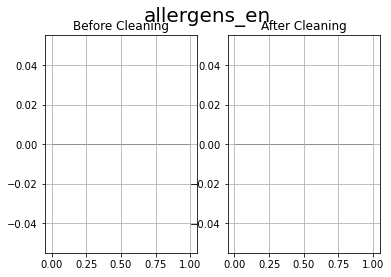

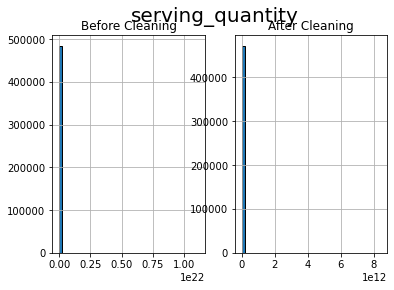

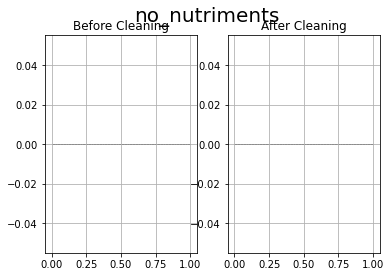

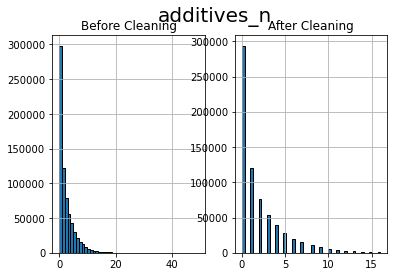

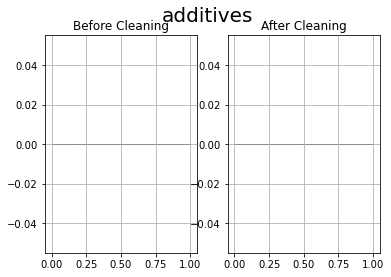

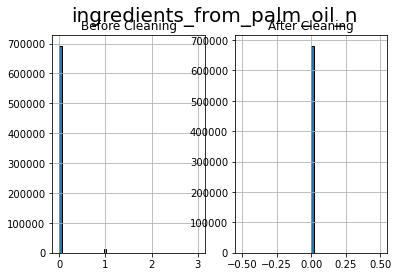

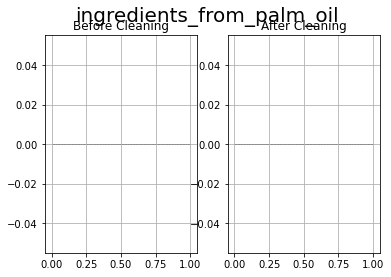

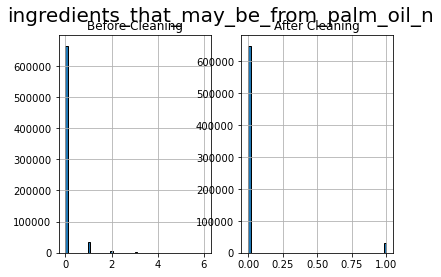

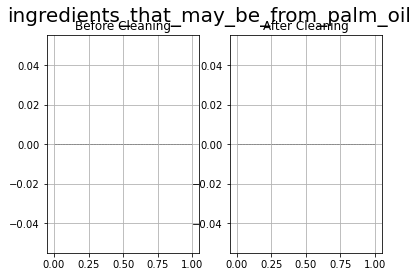

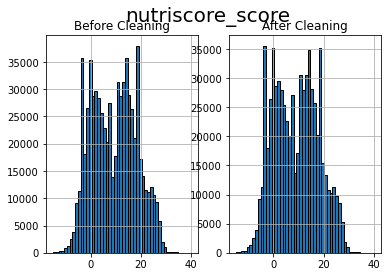

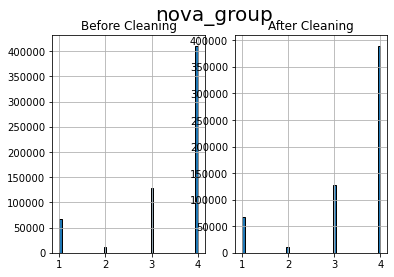

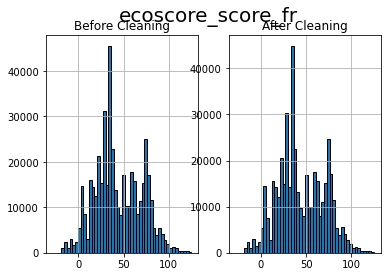

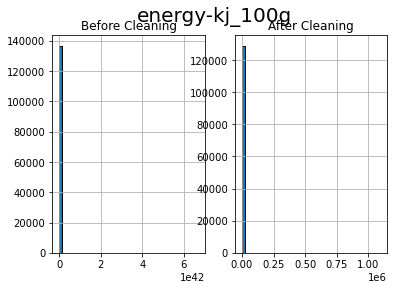

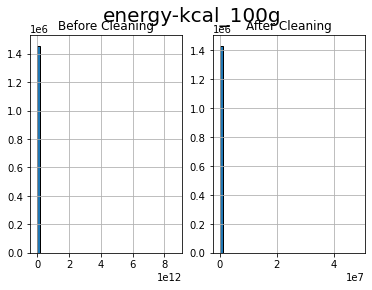

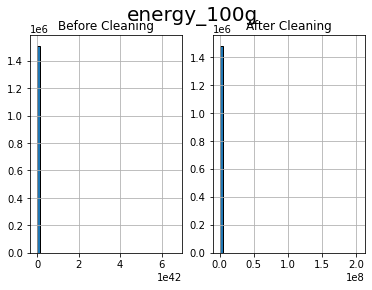

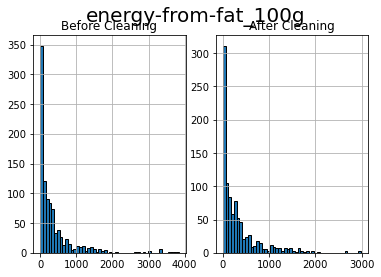

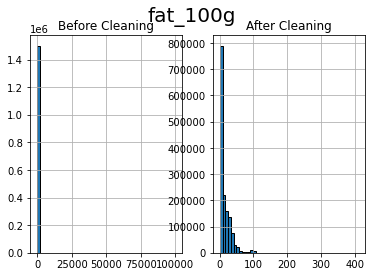

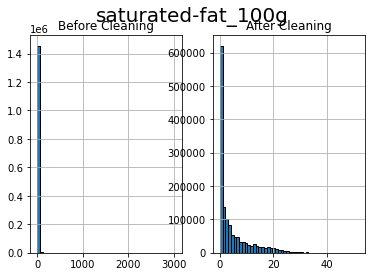

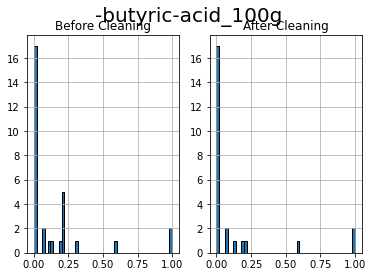

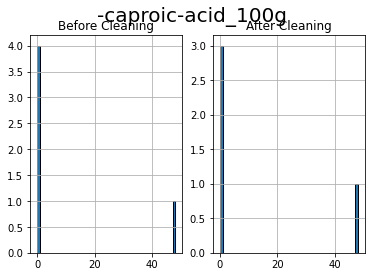

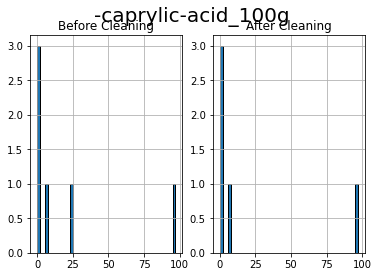

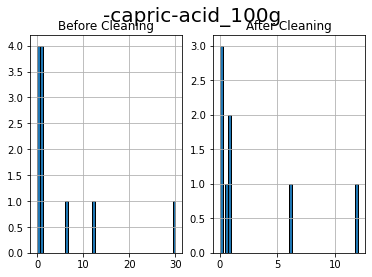

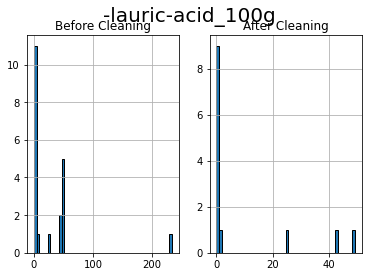

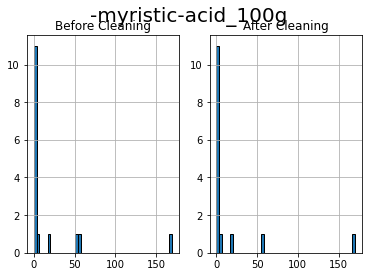

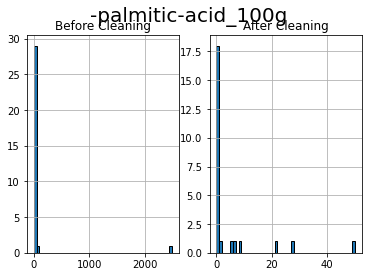

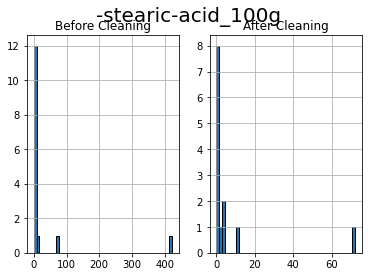

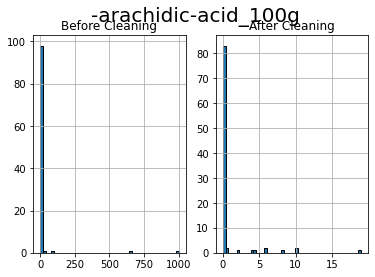

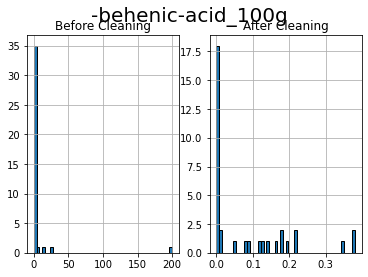

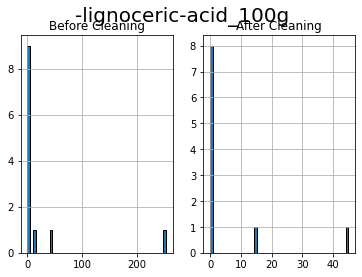

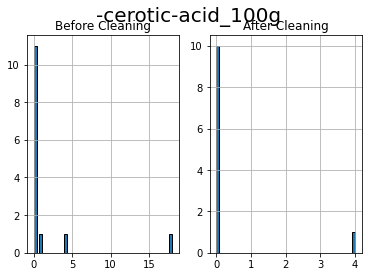

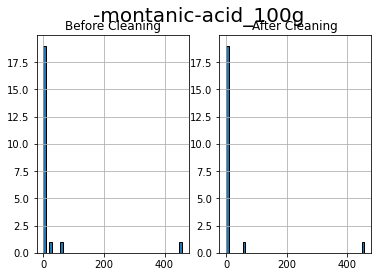

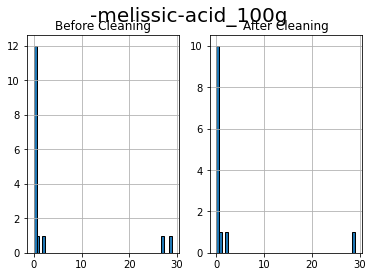

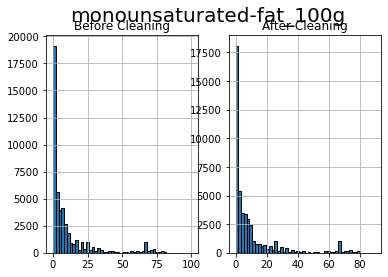

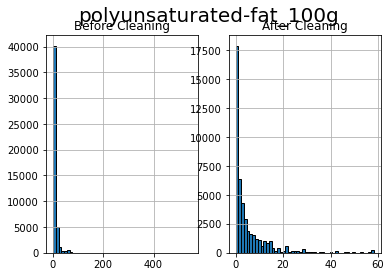

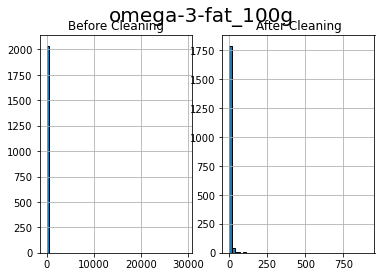

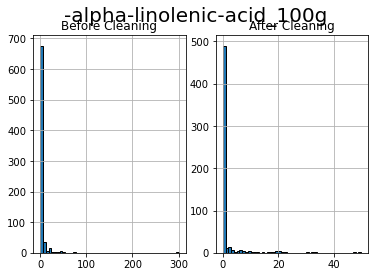

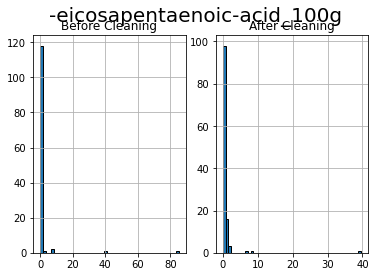

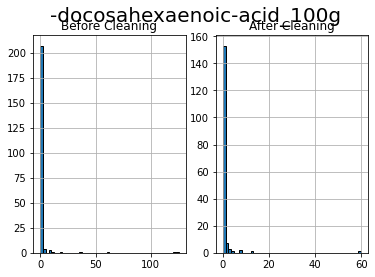

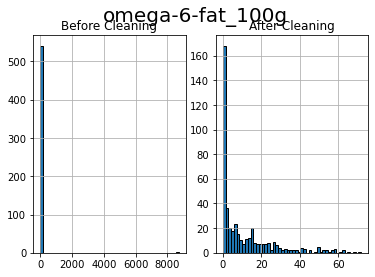

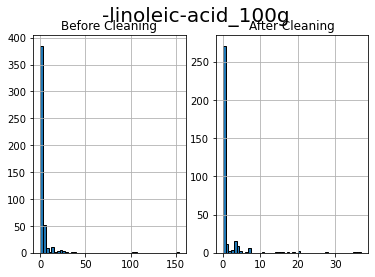

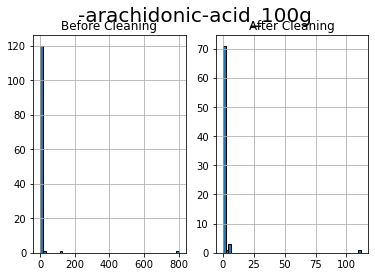

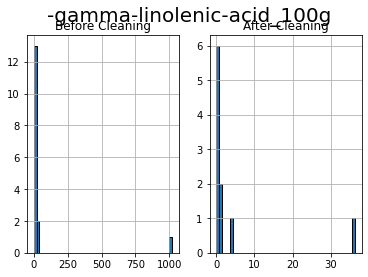

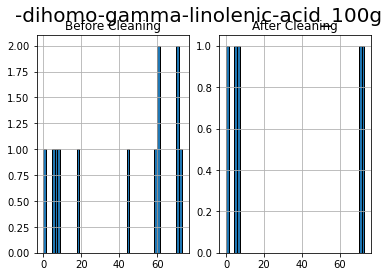

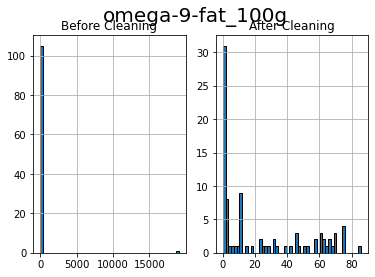

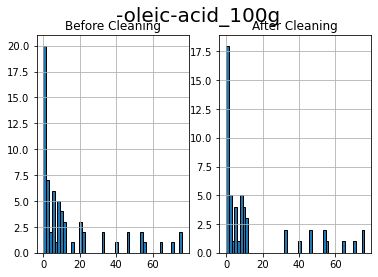

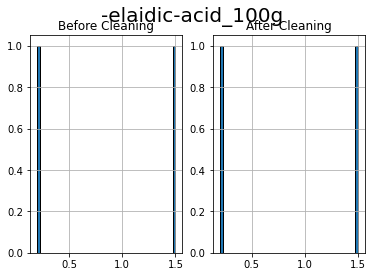

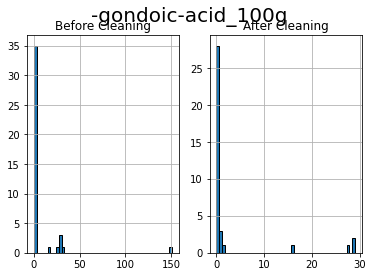

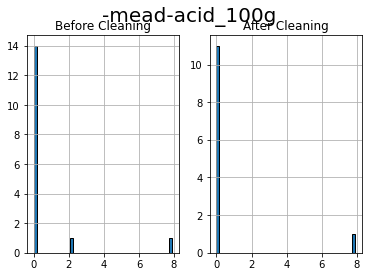

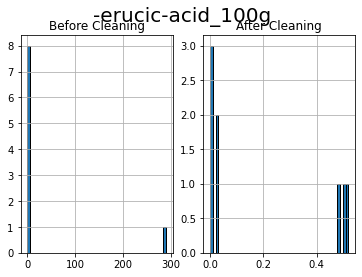

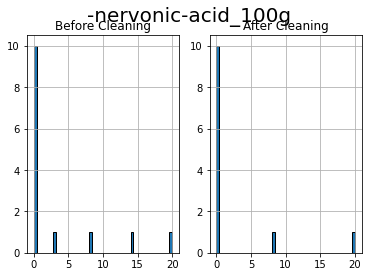

In [4]:
#Drop line if value > 5 std
idx=[]
for i in df[NUM]:
    Ser=abs(df[i]-df[i].mean())>5*df[i].std()
    idx=list(itertools.chain(idx,Ser[Ser].index))
    
df_drop=df.drop(idx,axis=0,)

#Visualisation
for i in df[NUM[0:50]]:
    fig, axes = plt.subplots(1, 2)#, figsize=(16,8))
    fig.suptitle(i,fontsize=20)
    axes[0].set_title("Before Cleaning")
    axes[1].set_title("After Cleaning")

    df[i].hist(bins=50,ax=axes[0],edgecolor='black')
    df_drop[i].hist(bins=50,ax=axes[1],edgecolor='black')

#Supression des groupes mal orthographiés
df.drop(df[df["pnns_groups_2"]=="Pizza pies and quiche"].index,axis=0,inplace=True)
df.drop(df[df["pnns_groups_2"]=="pastries"].index,axis=0,inplace=True)


In [5]:
print("Nombre de valeurs supprimées car > à 5 std : ",len(idx), ". Soit : "\
      ,round(len(idx)/len(df))*100," % du DataFrame originel" )

Nombre de valeurs supprimées car > à 5 std :  31428 . Soit :  0  % du DataFrame originel


### Imputer pour valeur manquantes ?

In [6]:
#variables eligibles: Aucune variable numerique
Threshold=0.80
var_to_fill=df_na[df_na["%nan"]<Threshold]
var_to_fill

,variable,%nan,unique_values
0,code,0.000000,1898531
1,url,0.000000,1898787
2,creator,0.000211,14099
3,created_t,0.000000,1647774
4,created_datetime,0.000000,1647774
5,last_modified_t,0.000000,1487242
6,last_modified_datetime,0.000000,1487242
34,countries,0.301349,10561
35,countries_tags,0.301612,4193
36,countries_en,0.301612,4193


In [18]:
#Apres visualisation difference df / df_drop : df = df_drop

df = df_drop

# Hypothèse ?  : Les produits de la même categorie ont des valeurs nutritionelles assez disparatre pour que la recommendation d'un même type de produit plus sain soit pertinente.


### Analyse de la variance intra "PNNS GROUPS"

In [19]:
df_group_nutri=pd.DataFrame(df.groupby("pnns_groups_2")["nutrition-score-fr_100g"].mean()).reset_index()
c=["energy-kcal_100g","fat_100g","fiber_100g","carbohydrates_100g","sugars_100g","proteins_100g","salt_100g"]
for i in c:
    df_group_nutri[i]=df.groupby("pnns_groups_2")[i].mean().values
    
#df.drop(df[df["pnns_groups_2"]=="Pizza pies and quiche"].index,axis=0,inplace=True)
#df.drop(df[df["pnns_groups_2"]=="pastries"].index,axis=0,inplace=True)

df_group_nutri

,pnns_groups_2,nutrition-score-fr_100g,energy-kcal_100g,fat_100g,fiber_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g
0,Alcoholic beverages,8.518519,78.854863,1.677342,0.771747,11.528985,7.333911,1.472252,0.944148
1,Appetizers,12.046914,457.062454,23.359639,4.310576,51.863842,3.550699,7.798461,1.642584
2,Artificially sweetened beverages,5.562671,66.437190,0.956825,1.045614,9.215043,5.198313,2.149390,0.379695
3,Biscuits and cakes,17.371138,422.940245,18.084241,2.985485,58.694104,28.556119,6.269432,0.853742
4,Bread,4.116290,303.052501,5.723240,4.300652,51.748282,4.619201,9.392642,1.331235
5,Breakfast cereals,5.035298,441.123454,8.327571,7.562969,65.672373,15.621803,9.698150,0.536209
6,Cereals,1.951092,354.029216,6.582936,5.062432,62.274452,6.641244,10.090409,0.528105
7,Cheese,14.039206,332.204657,26.289321,0.197113,2.641917,1.210502,20.740102,1.605408
8,Chocolate products,22.864613,545.861630,36.104869,6.078674,45.998781,39.764524,7.343972,0.258631
9,Dairy desserts,4.093734,141.990192,5.548451,0.600520,16.193658,12.172538,5.321135,0.250450


### Variance du nutriscore au sein de pnns_group


In [20]:
print("Pour tout le DataFrame, ecart type = ",df_drop["nutrition-score-fr_100g"].std())
print(df_drop.groupby("pnns_groups_2")["nutrition-score-fr_100g"].std())


Pour tout le DataFrame, ecart type =  8.805297978637416
pnns_groups_2
Alcoholic beverages                 7.223734
Appetizers                          5.984472
Artificially sweetened beverages    5.773687
Biscuits and cakes                  6.324026
Bread                               5.951239
Breakfast cereals                   6.875987
Cereals                             7.538992
Cheese                              4.195472
Chocolate products                  4.375578
Dairy desserts                      5.547601
Dressings and sauces                7.300906
Dried fruits                        4.857755
Eggs                                3.607434
Fats                                5.073788
Fish and seafood                    6.355822
Fruit juices                        3.598254
Fruit nectars                       4.714862
Fruits                              4.481614
Ice cream                           5.576915
Legumes                             6.753110
Meat                          

### ==> boxplot ?==> Ecart type plus faible au sein des groupes. Mais variance toujours présente ==> Possibilité de présenter un meilleur produit de la meme classe. ==> Perform ANOVA ?


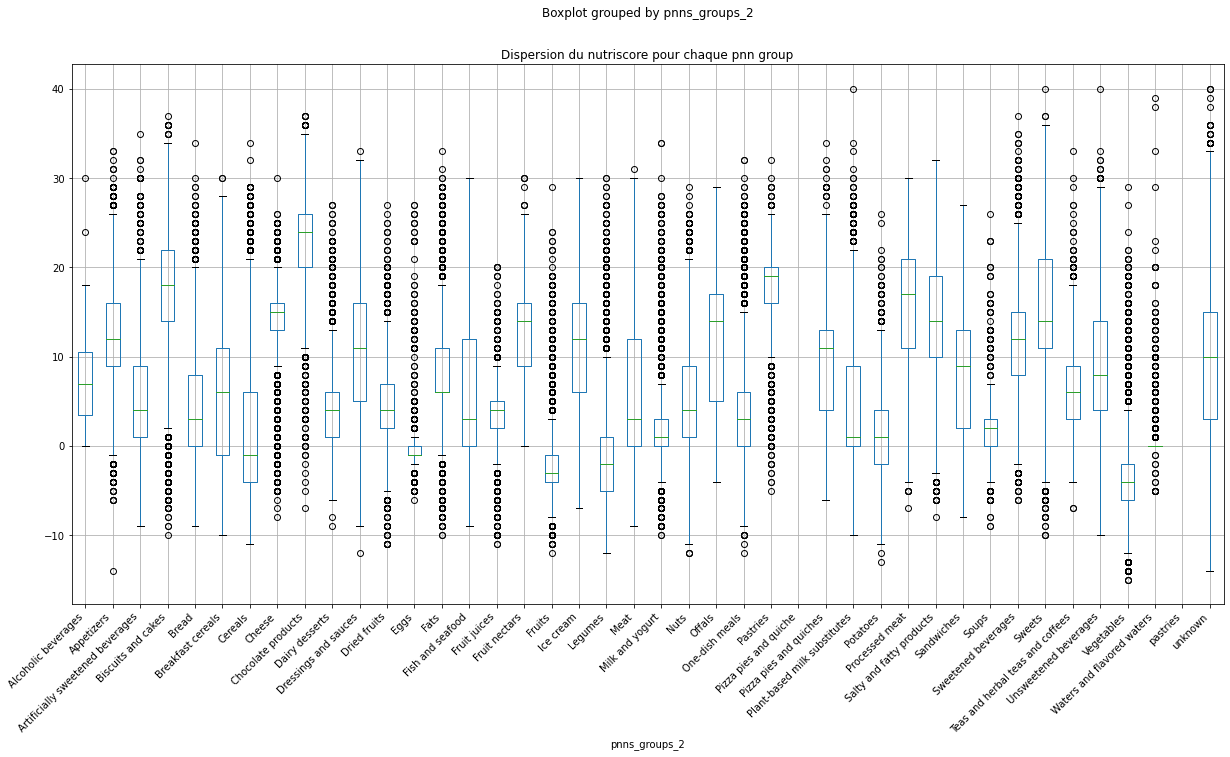

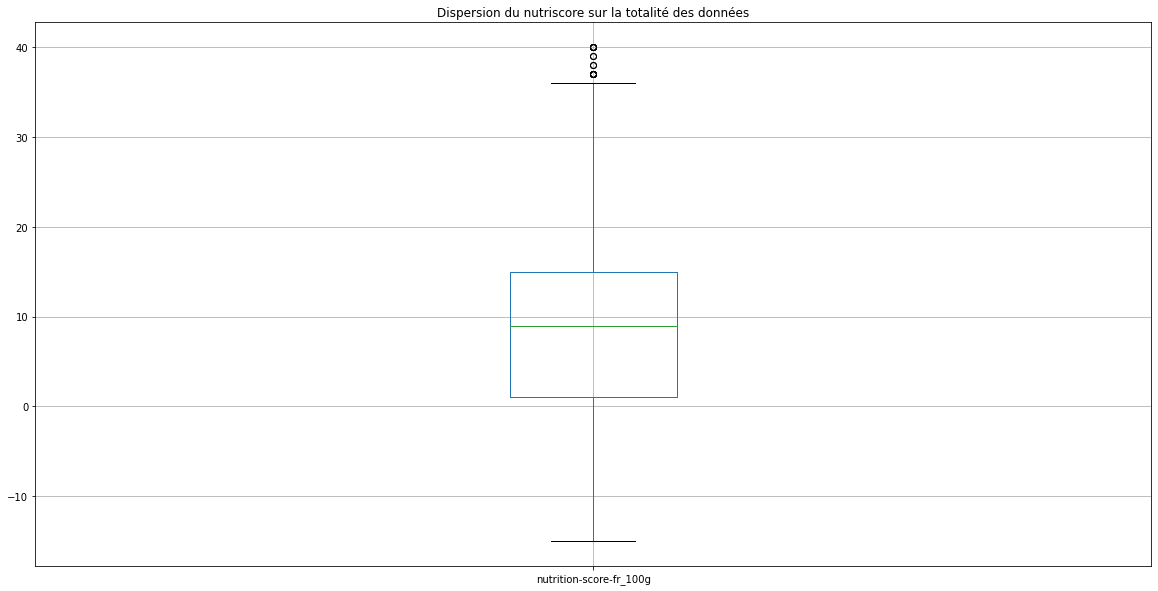

In [21]:
"""        PNN GROUPS - Boxplot    """
df.boxplot(column="nutrition-score-fr_100g",by="pnns_groups_2")#,ax=axs[0])#,rot=45)
plt.xticks(rotation=45, horizontalalignment='right',fontsize='medium'  )
plt.gcf().set_size_inches(20, 10)
plt.title("Dispersion du nutriscore pour chaque pnn group")

plt.figure(figsize=(20,10))
df.boxplot(column="nutrition-score-fr_100g")
plt.title("Dispersion du nutriscore sur la totalité des données")
plt.show()


# Hypothèse ?  : Le nutriscore d'un produit est proportionnel à sa concentration en gras/ sel/ sucre etc

## Analyse Bivariée / Multivariée

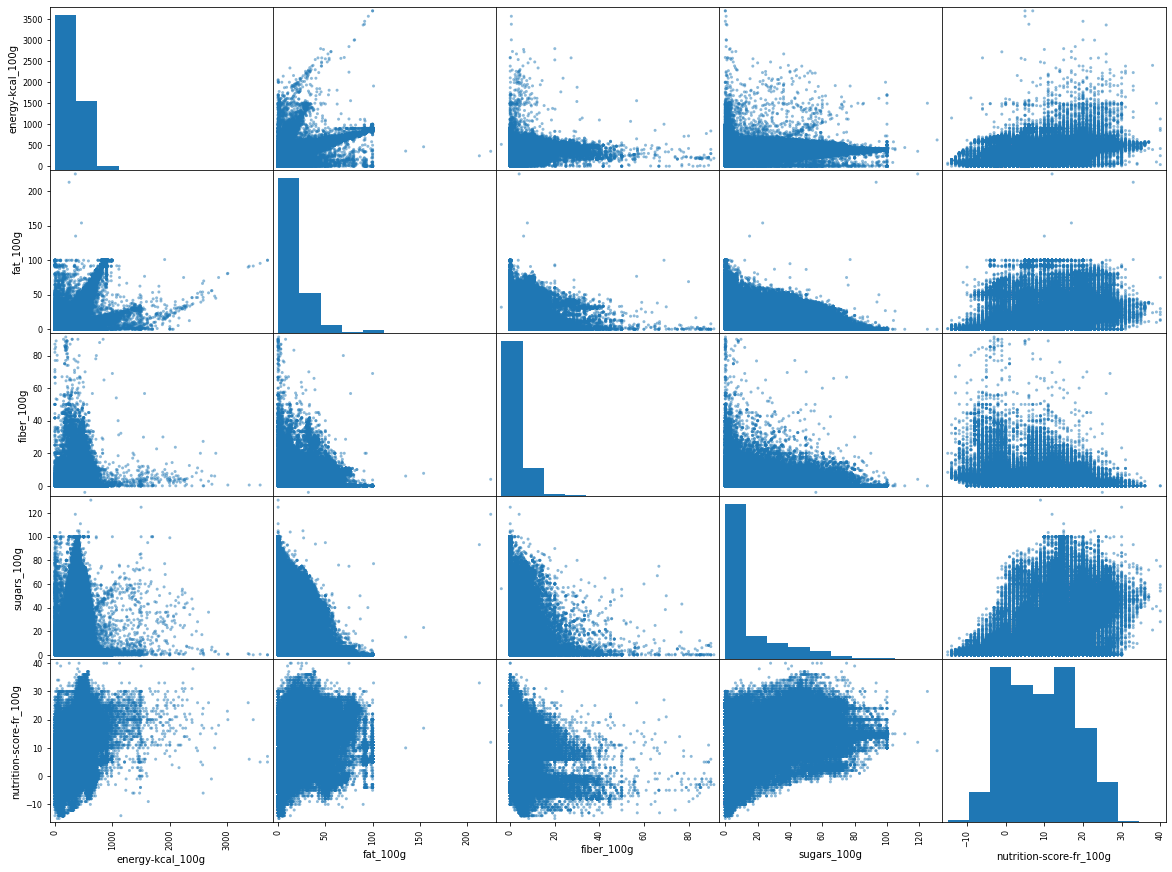

In [23]:
nutri=df[df['nutrition-score-fr_100g'].notnull()]\
[["product_name","energy-kcal_100g","fat_100g","fiber_100g","sugars_100g","proteins_100g","nutrition-score-fr_100g"]].reset_index(drop=True)

#energy outliers - mal modifier par 1er filtre => casse à 4 000
nutri=nutri[nutri["energy-kcal_100g"]<4000]


from pandas.plotting import scatter_matrix#Carefull TIME
scatter_matrix(nutri[["energy-kcal_100g","fat_100g","fiber_100g","sugars_100g","nutrition-score-fr_100g"]]\
               , figsize=(20, 15))
plt.show()

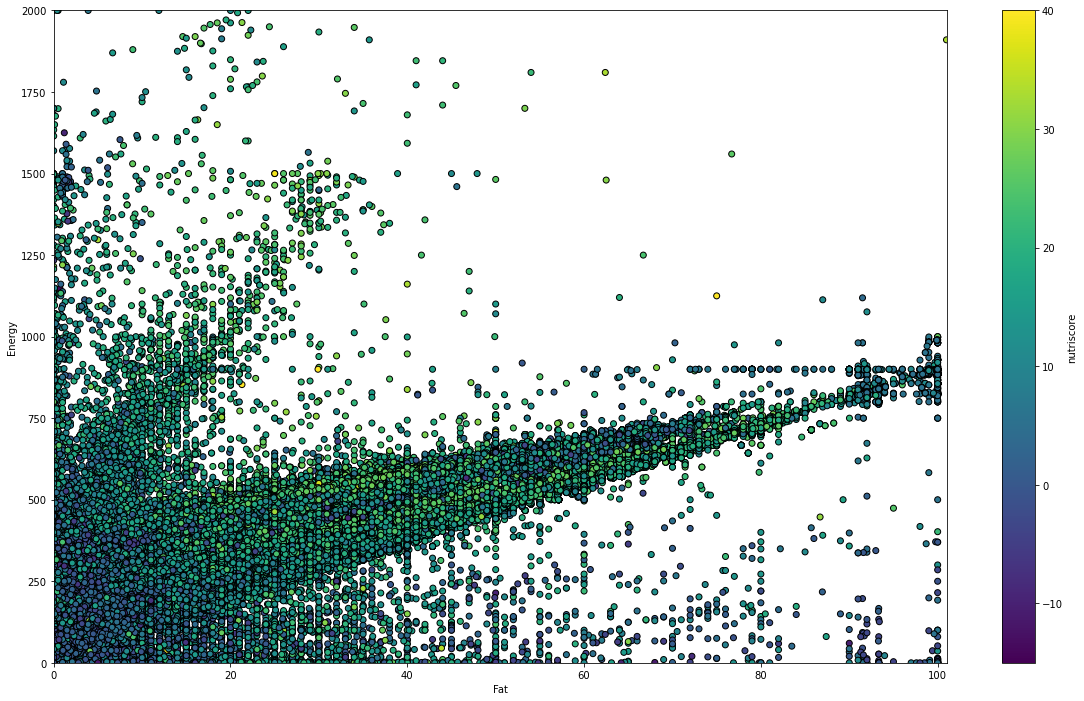

In [26]:
"""P L O T """
#fat/Energy
plt.figure(figsize=(20,12))
plt.scatter((nutri[ "fat_100g"]),
            nutri["energy-kcal_100g"],
            #s=........,
            c=nutri["nutrition-score-fr_100g"],
            edgecolors='black')
plt.colorbar(label='nutriscore')
plt.xlabel("Fat")
plt.ylabel("Energy")

#adapt axis
axes = plt.gca()
axes.set_ylim([0,2000])
axes.set_xlim([0,101])

plt.show()

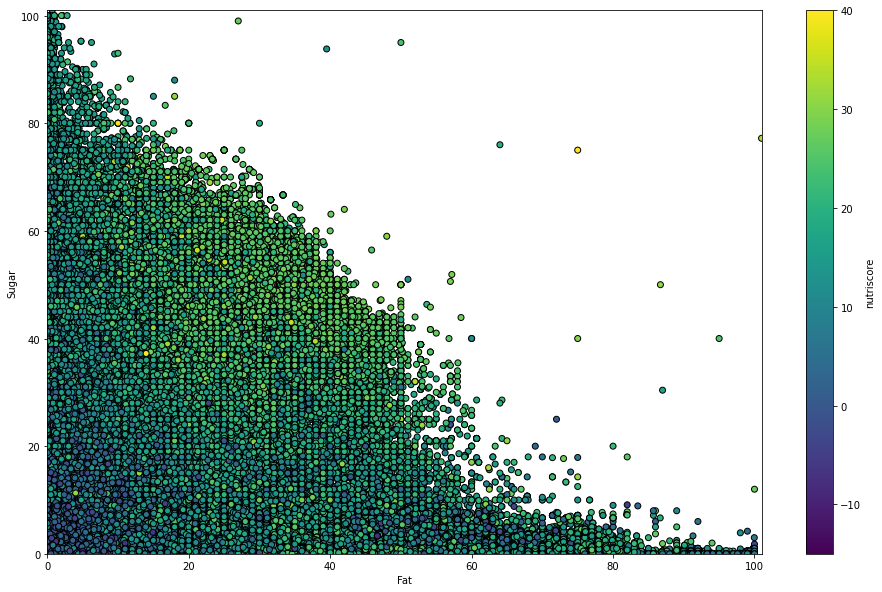

In [28]:
#fat/sugar
plt.figure(figsize=(16,10))
plt.scatter((nutri[ "fat_100g"]),
            nutri["sugars_100g"],
            c=nutri["nutrition-score-fr_100g"],
            edgecolors='black')
plt.colorbar(label='nutriscore')
plt.xlabel("Fat")
plt.ylabel("Sugar")

#adapt axis
axes = plt.gca()
axes.set_ylim([0,101])
axes.set_xlim([0,101])

plt.show()


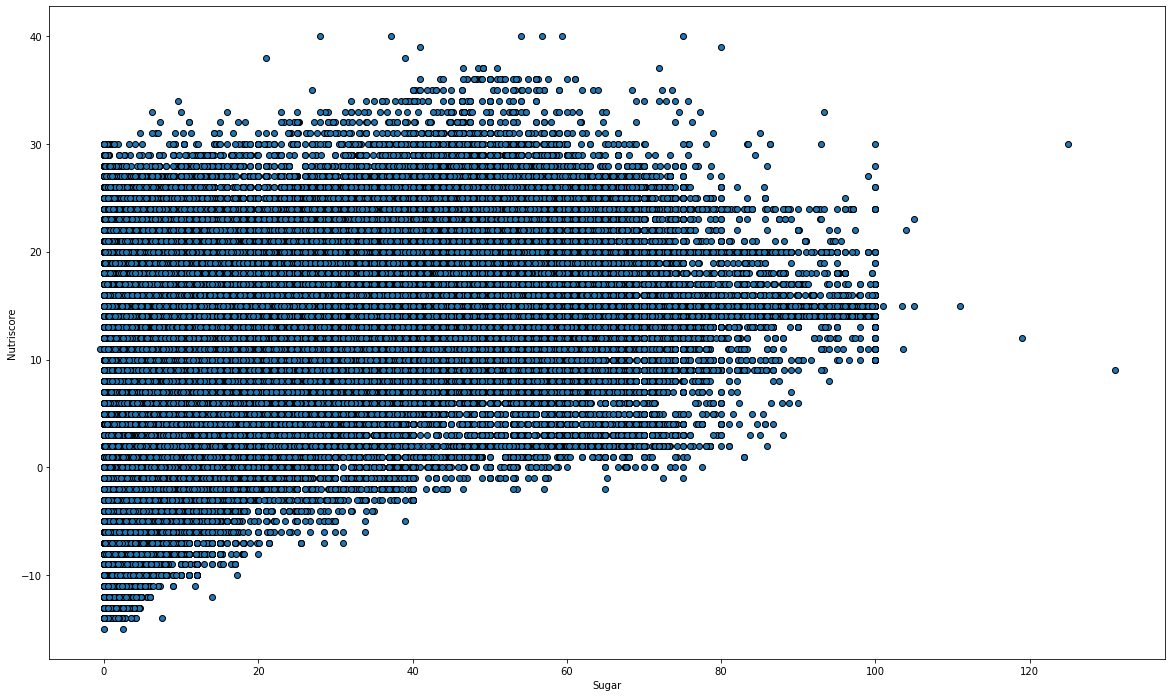

In [29]:
"""P L O T """
"""plot colour 3 infos"""
#fat/Energy
plt.figure(figsize=(20,12))
plt.scatter((nutri[ "sugars_100g"]),
            nutri["nutrition-score-fr_100g"],
            #s=........,
            edgecolors='black')
plt.xlabel("Sugar")
plt.ylabel("Nutriscore")
plt.show()

In [15]:
#nutri.hist(bins=50, figsize=(20,15))

# Divers

In [ ]:
# Pairplot  / Correlation / Join plot

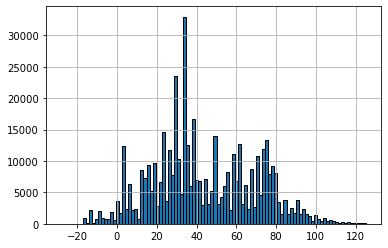

In [17]:
## I Analyse univariée sur l'ecoscore (Pourquoi?)
df.ecoscore_score_fr.describe()
df.ecoscore_score_fr.hist(bins=100, edgecolor="k")#=> Fonction continue

fig = plt.figure(figsize=(8,6))
ax = fig.gca()
df.boxplot(column='ecoscore_score_fr', ax=ax)
#???

In [33]:
nutri=df[df['nutrition-score-fr_100g'].notnull()][["product_name","energy-kcal_100g","fat_100g","fiber_100g","sugars_100g","proteins_100g","nutrition-score-fr_100g"]].reset_index(drop=True)

# Remove outliers
idx=[]
for i in nutri.columns[1:6]:
    Ser=abs(nutri[i]-nutri[i].mean()) > (3*nutri[i].std())
    idx=list(itertools.chain(idx,Ser[Ser].index))                                                                            
nutri.drop(idx,axis=0,inplace=True)

#energy outliers / casse à 4 000
nutri=nutri[nutri["energy-kcal_100g"]<4000]
